# Capstone Project - Restaurant Location Analysis
### Applied Data Science Capstone by IBM/Coursera

## Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

### Introduction - The Business problem <a name="introduction"></a>


According to CofaceBdi [https://finance.walla.co.il/item/3121784] Over 2017, Israelis have spent over 20 Billion shekels on the restaurant sector, a 3.5% increase from 2016. At the same time, the level of risk for the restaurant industry was measured at 6.86 (on a 1-10 scale), over 2018, 835 Israeli restaurants went out of business, while 2076 new venues were opened in this sector[https://www.mako.co.il/food-restaurants/restaurant-news/Article-a6166d8485ae761006.htm].

Although a lucrative sector, restaurant entrepreneurship is defined by a sizeable measure of risk, any potential business owner in this industry would benefit from maximizing his chances of success.

One of the most important factors leading to the success of a restaurant is its location. in this project, I will attempt to recommend, based on the available data and analysis of it, an optimal location for a new restaurant, and its preferable menu style, on the basis of existing venues in the different cities of Israel.

We will assume the business stakeholder in this situation is an entrepreneur interested in opening a new restaurant around Israel & in an urban environment, we will work under the assumption that the prevalence of specific menu types per area is indicative of the demand for that restaurant-style for a specific area.

We will also use socio-economic index data in order to segment Israeli cities, to try and differentiate between preferred venues, and eventually, make various recommendations based on this categorization.

## Data <a name="data"></a>

Based on our definition of the issue, we will require data sources that include - 

* A list of Israeli cities, including their longitude & latitude information 
* Socio-Economic Index per city
* Specification of venues in each city

Accordingly, these are the data sources that will be used - 

* We will scrape the Wikipedia table for Cities is Israel for its included list of Socio-Economic Index per city
* We will use a geolocating api to add longitude & latitude
* The list of venues per area will be accessed with the Foursquare API

In [35]:
### required libraries 

import requests
import pandas as pd
import folium
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import xlrd
import urllib.request
import io

from matplotlib.figure import Figure # import Figure Artist
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas # agg - anti green galery
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
from folium import plugins
from folium.plugins import HeatMap
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt


%matplotlib inline 

Lets scrape the wikipedia table located at:https://en.wikipedia.org/wiki/List_of_cities_in_Israel 

In [9]:
url = "https://en.wikipedia.org/wiki/List_of_cities_in_Israel"

In [14]:
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "lxml")

In [15]:
right_table=soup.find('table', class_='wikitable sortable') #create object for the table alone

In [16]:
#loop to scrape each column contents into a list
A=[]
B=[]
C=[]
D=[]
E=[]
F=[]
G=[]
H=[]
I=[]
J=[]

for row in right_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)>0:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))  
        D.append(cells[3].find(text=True))  
        E.append(cells[4].find(text=True))  
        F.append(cells[5].find(text=True))  
        G.append(cells[6].find(text=True))  
        H.append(cells[7].find(text=True))
        I.append(cells[8].find(text=True))  
        J.append(cells[9].find(text=True))

In [162]:
#create pandas df
df_socio=pd.DataFrame(A,columns=['Name'])
df_socio['First_settlement']=B
df_socio['District']=D
df_socio['Population_Estimate_2018']=E
df_socio['Population_Census_2008']=F
df_socio['Change_2008_2018']=G
df_socio['Area_KM']=H
df_socio['Density_Per_KM']=I
df_socio['Socio_Economic_Index']=J
df_socio.head(10)

,Name,First_settlement,District,Population_Estimate_2018,Population_Census_2008,Change_2008_2018,Area_KM,Density_Per_KM,Socio_Economic_Index
0,Acre,Bronze Age,North,"48,930","46,100",+6.14%,13.5,"3,362.0",−0.395
1,Afula,Bronze Age,North,"51,737","40,200",+28.70%,26.9,"1,611.7",−0.028
2,Arad,1962,South,"26,451","23,400",+13.04%,93.1,195.9,0.287
3,Arraba,N/A,North,"25,369","20,600",+23.15%,8.25,"3,097.1",−0.945
4,Ashdod,Bronze Age,South,"224,628","204,300",+9.95%,47.2,"4,783.9",−0.109
5,Ashkelon,Neolithic,South,"140,968","110,600",+27.46%,47.8,"2,964.8",-0.032
6,Baqa al-Gharbiyye,Middle Ages,Haifa,"29,393",N/A,N/A,16.4,"3,152.1",−0.736
7,Bat Yam,1926,Tel Aviv,"128,774","130,300",−1.17%,8.2,"15,758.4",−0.025
8,Beersheba,1900,South,"209,002","193,400",+8.07%,117.5,"1,751.7",0.035
9,Beit She'an,Neolithic,North,"18,227","16,900",+7.85%,7.3,"2,379.9",−0.277


In [18]:
df_socio.describe(include="all")

,Name,First_settlement,District,Population_Estimate_2018,Population_Census_2008,Change_2008_2018,Area_KM,Density_Per_KM,Socio_Economic_Index
count,73,73,73,73,73,73,73,73,73
unique,73,42,6,73,70,73,68,73,72
top,Giv'at Shmuel,Bronze Age,Center,"51,737","35,700",+7.85%,21.6,"13,138.6",−1.011
freq,1,9,21,1,2,1,2,1,2


In [166]:
## lets start clening the data
# drop un-neccesery columns

df_socio.drop(['First_settlement'], axis=1, inplace=True)
df_socio.drop(['Change_2008_2018'], axis=1, inplace=True)




# remove row with missing data
df_socio = df_socio[df_socio.Population_Census_2008 != 'N/A'].reset_index().drop('index', axis = 1)



## make sure all variables are correct type, remove \n and non numeric signs beforehand
df_socio['Population_Estimate_2018'] = df_socio['Population_Estimate_2018'].str.replace(r'\n', '')
df_socio['Population_Estimate_2018'] = df_socio['Population_Estimate_2018'].str.replace(r',', '')
df_socio['Population_Census_2008'] = df_socio['Population_Census_2008'].str.replace(r'\n', '')
df_socio['Population_Census_2008'] = df_socio['Population_Census_2008'].str.replace(r',', '')
df_socio['Density_Per_KM'] = df_socio['Density_Per_KM'].str.replace(r'\n', '')
df_socio['Density_Per_KM'] = df_socio['Density_Per_KM'].str.replace(r',', '')
df_socio['Socio_Economic_Index'] = df_socio['Socio_Economic_Index'].str.replace(r'\n', '')



df_socio['Area_KM'] = df_socio['Area_KM'].apply(pd.to_numeric, errors='coerce')


df_socio[['Population_Estimate_2018','Population_Census_2008','Density_Per_KM']] = df_socio[['Population_Estimate_2018','Population_Census_2008','Density_Per_KM']].astype(float)


df_socio.dtypes




Name                         object
District                     object
Population_Estimate_2018    float64
Population_Census_2008      float64
Area_KM                     float64
Density_Per_KM              float64
Socio_Economic_Index         object
dtype: object

In [176]:
# our current Socio - Economic index scale is unusabele, since changing it to a float will not retain - and + signs, lets import a more relevent format for this data.
# using: https://web.archive.org/web/20180113093008/http://www.cbs.gov.il/hodaot2016n/24_16_330t2.pdf
extea_socio=pd.read_csv(r'C:\Users\Owner\Documents\GitHub\Coursera_Capstone\Socio.csv')

extea_socio.head()

,Name,Socio_Economic_Cluster,Socio_Economic_Ranking
0,Acre,4,96
1,Afula,5,129
2,Arad,4,105
3,Arraba,2,49
4,Ashdod,5,118


In [181]:
# Socio_Economic_Cluster: Precentile groups, 1-lo1, 10-high
# Socio_Economic_Ranking - Rank among all Iseaeli Settelments, goes from 1- low, to 256 high
# lets drop the redundent column and merge the new ones into our dataframe

df_socio.drop(['Socio_Economic_Index'], axis=1, inplace=True)

df_socio = pd.merge(df_socio, extea_socio, how="left", on=["Name"])

df_socio.describe(include="all")


,Name,District,Population_Estimate_2018,Population_Census_2008,Area_KM,Density_Per_KM,Socio_Economic_Cluster,Socio_Economic_Ranking
count,72,72,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
unique,72,6,NaN,NaN,NaN,NaN,NaN,NaN
top,Giv'at Shmuel,Center,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,21,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,89305.277778,76204.166667,22.770139,4689.498611,5.138889,134.583333
std,NaN,NaN,126276.421100,107197.703935,24.930314,4225.627593,2.078092,65.780846
min,NaN,NaN,18227.000000,16000.000000,2.600000,193.700000,1.000000,11.000000
25%,NaN,NaN,29702.750000,24825.000000,8.050000,2276.925000,3.750000,90.000000
50%,NaN,NaN,47293.000000,39600.000000,14.150000,3131.200000,5.000000,132.000000
75%,NaN,NaN,93090.000000,71950.000000,27.425000,5749.875000,7.000000,188.250000


In [170]:
df_socio.head(10)

,Name,District,Population_Estimate_2018,Population_Census_2008,Area_KM,Density_Per_KM,Socio_Economic_Index
0,Acre,North,48930.0,46100.0,13.50,3362.0,−0.395
1,Afula,North,51737.0,40200.0,26.90,1611.7,−0.028
2,Arad,South,26451.0,23400.0,93.10,195.9,0.287
3,Arraba,North,25369.0,20600.0,8.25,3097.1,−0.945
4,Ashdod,South,224628.0,204300.0,47.20,4783.9,−0.109
5,Ashkelon,South,140968.0,110600.0,47.80,2964.8,-0.032
6,Bat Yam,Tel Aviv,128774.0,130300.0,8.20,15758.4,−0.025
7,Beersheba,South,209002.0,193400.0,117.50,1751.7,0.035
8,Beit She'an,North,18227.0,16900.0,7.30,2379.9,−0.277
9,Beit Shemesh,Jerusalem,118676.0,72700.0,34.30,2866.6,−1.149


### Add longitude & latitude 

We will use the OpenCage Geocoder 

In [19]:
!pip install opencage
from opencage.geocoder import OpenCageGeocode

In [20]:
key = 'Use your key here' # get api key from:  https://opencagedata.com

In [182]:

	
geocoder = OpenCageGeocode(key)



	
query = 'Tel Aviv'  



	
results = geocoder.geocode(query)



lat = results[0]['geometry']['lat']

lng = results[0]['geometry']['lng']

print (lat, lng)

32.0854162 34.7817131


In [183]:
# now for all cities in our df:
list_lat = []   # create empty lists

list_long = []


	
for index, row in df_socio.iterrows(): # iterate over rows in dataframe



    City = row['Name']
    State = 'Israel'       
    query = str(City)+','+str(State)

    results = geocoder.geocode(query)   
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']

    list_lat.append(lat)
    list_long.append(long)

	
# create new columns from lists    

df_socio['latitude'] = list_lat   

df_socio['longitude'] = list_long

In [184]:
df_socio.head()

,Name,District,Population_Estimate_2018,Population_Census_2008,Area_KM,Density_Per_KM,Socio_Economic_Cluster,Socio_Economic_Ranking,latitude,longitude
0,Acre,North,48930.0,46100.0,13.50,3362.0,4,96,32.928173,35.075638
1,Afula,North,51737.0,40200.0,26.90,1611.7,5,129,32.607559,35.289086
2,Arad,South,26451.0,23400.0,93.10,195.9,4,105,31.261220,35.214581
3,Arraba,North,25369.0,20600.0,8.25,3097.1,2,49,32.848613,35.335827
4,Ashdod,South,224628.0,204300.0,47.20,4783.9,5,118,31.797731,34.652992


Lets Create a map of Israel with cities superimposed on top

In [206]:

map_Israel = folium.Map(location=[31, 35], zoom_start=7)

# add markers to map
for lat, lng, Name, District in zip(df_socio['latitude'], df_socio['longitude'], df_socio['Name'], df_socio['District']):
    label = '{}, {}'.format(Name, District)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Israel)  
    
map_Israel

In [210]:
# save as an html file
map_Israel.save("Cities.html")

## Foursquare

Now that all of our locations are set, lets get venue data for all cities.
We will make a call to the Foursquare API for all venues in the vicinity of each city.

Our results will include non-food related venues, we'll get rid of those later

In [37]:
#Define Foursquare Credentials and Version

CLIENT_ID = 'set your id' # your Foursquare ID
CLIENT_SECRET = 'set your pass' # your Foursquare Secret
VERSION = '20200713' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID has been set ' )
print('CLIENT_SECRET has been set')


Your credentails:
CLIENT_ID has been set 
CLIENT_SECRET has been set


In [186]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 4000 # define radius

In [187]:
 #create a function to get venus for all the cities in Israel

def getNearbyVenues(names, latitudes, longitudes, radius=4000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("Finished!")
    
    return(nearby_venues)

In [320]:
# write the code to run the above function on each city and create a new dataframe called Israel_venues


Israel_venues = getNearbyVenues(names=df_socio['Name'],
                                 latitudes=df_socio['latitude'],
                                 longitudes=df_socio['longitude'],
                                 radius = 4000
                                )

Finished!


In [321]:
#merge variables check the size of the resulting dataframe
df_socio.rename(columns={'Name':'City'}, inplace=True)
Israel_venues = pd.merge(Israel_venues, df_socio, how="left", on=["City"])

print(Israel_venues.shape)
Israel_venues

(2763, 16)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,District,Population_Estimate_2018,Population_Census_2008,Area_KM,Density_Per_KM,Socio_Economic_Cluster,Socio_Economic_Ranking,latitude,longitude
0,Acre,32.928173,35.075638,Old City of Acre / Akko (העיר העתיקה של עכו),32.922891,35.070638,Historic Site,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638
1,Acre,32.928173,35.075638,Uri Buri,32.920179,35.066798,Seafood Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638
2,Acre,32.928173,35.075638,The Crusader Citadel (Citadel of Acre),32.923712,35.070589,Historic Site,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638
3,Acre,32.928173,35.075638,Kukushka - Premium Snack Bar - קוקושקה,32.922540,35.069923,Tapas Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638
4,Acre,32.928173,35.075638,Effendi Hotel,32.922566,35.068062,Hotel,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638
5,Acre,32.928173,35.075638,Hummus Said (חומוס סעיד),32.921535,35.069755,Middle Eastern Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638
6,Acre,32.928173,35.075638,Suhila Hummus (חומוס סוהילה),32.922480,35.071718,Mediterranean Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638
7,Acre,32.928173,35.075638,Doniana,32.919306,35.068455,Asian Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638
8,Acre,32.928173,35.075638,El Marsa,32.920104,35.070044,Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638
9,Acre,32.928173,35.075638,חוף הים,32.935526,35.072735,Scenic Lookout,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638


In [115]:
# retain only food-related categories
# from https://developer.foursquare.com/docs/build-with-foursquare/categories/

listings = ["Afghan Restaurant",
"African Restaurant",
"Ethiopian Restaurant",
"American Restaurant",
"New American Restaurant",
"Asian Restaurant",
"Burmese Restaurant",
"Cambodian Restaurant",
"Chinese Restaurant",
"Anhui Restaurant",
"Beijing Restaurant",
"Cantonese Restaurant",
"Cha Chaan Teng",
"Chinese Aristocrat Restaurant",
"Chinese Breakfast Place",
"Dim Sum Restaurant",
"Dongbei Restaurant",
"Fujian Restaurant",
"Guizhou Restaurant",
"Hainan Restaurant",
"Hakka Restaurant",
"Henan Restaurant",
"Hong Kong Restaurant",
"Huaiyang Restaurant",
"Hubei Restaurant",
"Hunan Restaurant",
"Imperial Restaurant",
"Jiangsu Restaurant",
"Jiangxi Restaurant",
"Macanese Restaurant",
"Manchu Restaurant",
"Peking Duck Restaurant",
"Shaanxi Restaurant",
"Shandong Restaurant",
"Shanghai Restaurant",
"Shanxi Restaurant",
"Szechuan Restaurant",
"Taiwanese Restaurant",
"Tianjin Restaurant",
"Xinjiang Restaurant",
"Yunnan Restaurant",
"Zhejiang Restaurant",
"Filipino Restaurant",
"Himalayan Restaurant",
"Hotpot Restaurant",
"Indonesian Restaurant",
"Acehnese Restaurant",
"Balinese Restaurant",
"Betawinese Restaurant",
"Indonesian Meatball Place",
"Javanese Restaurant",
"Manadonese Restaurant",
"Padangnese Restaurant",
"Sundanese Restaurant",
"Japanese Restaurant",
"Donburi Restaurant",
"Japanese Curry Restaurant",
"Kaiseki Restaurant",
"Kushikatsu Restaurant",
"Monjayaki Restaurant",
"Nabe Restaurant",
"Okonomiyaki Restaurant",
"Ramen Restaurant",
"Shabu-Shabu Restaurant",
"Soba Restaurant",
"Sukiyaki Restaurant",
"Sushi Restaurant",
"Takoyaki Place",
"Tempura Restaurant",
"Tonkatsu Restaurant",
"Udon Restaurant",
"Unagi Restaurant",
"Wagashi Place",
"Yakitori Restaurant",
"Yoshoku Restaurant",
"Korean Restaurant",
"Bossam/Jokbal Restaurant",
"Bunsik Restaurant",
"Gukbap Restaurant",
"Janguh Restaurant",
"Samgyetang Restaurant",
"Malay Restaurant",
"Mamak Restaurant",
"Mongolian Restaurant",
"Noodle House",
"Satay Restaurant",
"Thai Restaurant",
"Som Tum Restaurant",
"Tibetan Restaurant",
"Vietnamese Restaurant",
"Australian Restaurant",
"Austrian Restaurant",
"BBQ Joint",
"Bagel Shop",
"Bakery",
"Bangladeshi Restaurant",
"Belgian Restaurant",
"Bistro",
"Breakfast Spot",
"Bubble Tea Shop",
"Buffet",
"Burger Joint",
"Cafeteria",
"Café",
"Cajun / Creole Restaurant",
"Caribbean Restaurant",
"Cuban Restaurant",
"Caucasian Restaurant",
"Coffee Shop",
"Comfort Food Restaurant",
"Creperie",
"Czech Restaurant",
"Deli / Bodega",
"Dessert Shop",
"Cupcake Shop",
"Frozen Yogurt Shop",
"Ice Cream Shop",
"Pastry Shop",
"Pie Shop",
"Diner",
"Donut Shop",
"Dumpling Restaurant",
"Dutch Restaurant",
"Eastern European Restaurant",
"Belarusian Restaurant",
"Bosnian Restaurant",
"Bulgarian Restaurant",
"Romanian Restaurant",
"Tatar Restaurant",
"English Restaurant",
"Falafel Restaurant",
"Fast Food Restaurant",
"Fish & Chips Shop",
"Fondue Restaurant",
"Food Court",
"Food Stand",
"Food Truck",
"French Restaurant",
"Alsatian Restaurant",
"Auvergne Restaurant",
"Basque Restaurant",
"Brasserie",
"Breton Restaurant",
"Burgundian Restaurant",
"Catalan Restaurant",
"Ch'ti Restaurant",
"Corsican Restaurant",
"Estaminet",
"Labour Canteen",
"Lyonese Bouchon",
"Norman Restaurant",
"Provençal Restaurant",
"Savoyard Restaurant",
"Southwestern French Restaurant",
"Fried Chicken Joint",
"Friterie",
"Gastropub",
"German Restaurant",
"Apple Wine Pub",
"Bavarian Restaurant",
"Bratwurst Joint",
"Currywurst Joint",
"Franconian Restaurant",
"German Pop-Up Restaurant",
"Palatine Restaurant",
"Rhenisch Restaurant",
"Schnitzel Restaurant",
"Silesian Restaurant",
"Swabian Restaurant",
"Gluten-free Restaurant",
"Greek Restaurant",
"Bougatsa Shop",
"Cretan Restaurant",
"Fish Taverna",
"Grilled Meat Restaurant",
"Kafenio",
"Magirio",
"Meze Restaurant",
"Modern Greek Restaurant",
"Ouzeri",
"Patsa Restaurant",
"Souvlaki Shop",
"Taverna",
"Tsipouro Restaurant",
"Halal Restaurant",
"Hawaiian Restaurant",
"Poke Place",
"Hot Dog Joint",
"Hungarian Restaurant",
"Indian Restaurant",
"Andhra Restaurant",
"Awadhi Restaurant",
"Bengali Restaurant",
"Chaat Place",
"Chettinad Restaurant",
"Dhaba",
"Dosa Place",
"Goan Restaurant",
"Gujarati Restaurant",
"Hyderabadi Restaurant",
"Indian Chinese Restaurant",
"Indian Sweet Shop",
"Irani Cafe",
"Jain Restaurant",
"Karnataka Restaurant",
"Kerala Restaurant",
"Maharashtrian Restaurant",
"Mughlai Restaurant",
"Multicuisine Indian Restaurant",
"North Indian Restaurant",
"Northeast Indian Restaurant",
"Parsi Restaurant",
"Punjabi Restaurant",
"Rajasthani Restaurant",
"South Indian Restaurant",
"Udupi Restaurant",
"Irish Pub",
"Italian Restaurant",
"Abruzzo Restaurant",
"Agriturismo",
"Aosta Restaurant",
"Basilicata Restaurant",
"Calabria Restaurant",
"Campanian Restaurant",
"Emilia Restaurant",
"Friuli Restaurant",
"Ligurian Restaurant",
"Lombard Restaurant",
"Malga",
"Marche Restaurant",
"Molise Restaurant",
"Piadineria",
"Piedmontese Restaurant",
"Puglia Restaurant",
"Romagna Restaurant",
"Roman Restaurant",
"Sardinian Restaurant",
"Sicilian Restaurant",
"South Tyrolean Restaurant",
"Trattoria/Osteria",
"Trentino Restaurant",
"Tuscan Restaurant",
"Umbrian Restaurant",
"Veneto Restaurant",
"Jewish Restaurant",
"Kosher Restaurant",
"Juice Bar",
"Kebab Restaurant",
"Latin American Restaurant",
"Arepa Restaurant",
"Empanada Restaurant",
"Salvadoran Restaurant",
"South American Restaurant",
"Argentinian Restaurant",
"Brazilian Restaurant",
"Acai House",
"Baiano Restaurant",
"Central Brazilian Restaurant",
"Churrascaria",
"Empada House",
"Goiano Restaurant",
"Mineiro Restaurant",
"Northeastern Brazilian Restaurant",
"Northern Brazilian Restaurant",
"Pastelaria",
"Southeastern Brazilian Restaurant",
"Southern Brazilian Restaurant",
"Tapiocaria",
"Colombian Restaurant",
"Peruvian Restaurant",
"Venezuelan Restaurant",
"Mac & Cheese Joint",
"Mediterranean Restaurant",
"Moroccan Restaurant",
"Mexican Restaurant",
"Botanero",
"Burrito Place",
"Taco Place",
"Tex-Mex Restaurant",
"Yucatecan Restaurant",
"Middle Eastern Restaurant",
"Egyptian Restaurant",
"Iraqi Restaurant",
"Israeli Restaurant",
"Kurdish Restaurant",
"Lebanese Restaurant",
"Persian Restaurant",
"Ash and Haleem Place",
"Dizi Place",
"Gilaki Restaurant",
"Jegaraki",
"Tabbakhi",
"Shawarma Place",
"Syrian Restaurant",
"Yemeni Restaurant",
"Modern European Restaurant",
"Molecular Gastronomy Restaurant",
"Pakistani Restaurant",
"Pet Café",
"Pizza Place",
"Polish Restaurant",
"Portuguese Restaurant",
"Poutine Place",
"Restaurant",
"Russian Restaurant",
"Blini House",
"Pelmeni House",
"Salad Place",
"Sandwich Place",
"Scandinavian Restaurant",
"Scottish Restaurant",
"Seafood Restaurant",
"Slovak Restaurant",
"Snack Place",
"Soup Place",
"Southern / Soul Food Restaurant",
"Spanish Restaurant",
"Paella Restaurant",
"Tapas Restaurant",
"Sri Lankan Restaurant",
"Steakhouse",
"Swiss Restaurant",
"Tea Room",
"Theme Restaurant",
"Truck Stop",
"Turkish Restaurant",
"Borek Place",
"Cigkofte Place",
"Doner Restaurant",
"Gozleme Place",
"Kofte Place",
"Kokoreç Restaurant",
"Kumpir Restaurant",
"Kumru Restaurant",
"Manti Place",
"Meyhane",
"Pide Place",
"Pilavcı",
"Söğüş Place",
"Tantuni Restaurant",
"Turkish Coffeehouse",
"Turkish Home Cooking Restaurant",
"Çöp Şiş Place",
"Ukrainian Restaurant",
"Varenyky restaurant",
"West-Ukrainian Restaurant",
"Vegetarian / Vegan Restaurant",
"Wings Joint"]

In [322]:
Israel_venues['Venue Category'].isin(listings)
Israel_venues = Israel_venues[Israel_venues['Venue Category'].isin(listings)]

In [323]:
#Let's find out how many unique categories can be curated from all the returned resturants

print('There are {} uniques categories.'.format(len(Israel_venues['Venue Category'].unique())))
Israel_venues['Venue Category'].unique()

There are 62 uniques categories.


array(['Seafood Restaurant', 'Tapas Restaurant',
       'Middle Eastern Restaurant', 'Mediterranean Restaurant',
       'Asian Restaurant', 'Restaurant', 'Café', 'Burger Joint',
       'Caucasian Restaurant', 'Sushi Restaurant', 'Coffee Shop',
       'Fast Food Restaurant', 'Breakfast Spot', 'French Restaurant',
       'Ice Cream Shop', 'Gastropub', 'Spanish Restaurant', 'Pizza Place',
       'BBQ Joint', 'Eastern European Restaurant', 'Bakery',
       'Chinese Restaurant', 'Food Truck', 'Italian Restaurant',
       'Dessert Shop', 'Steakhouse', 'Sandwich Place', 'Diner',
       'Indian Restaurant', 'American Restaurant', 'Thai Restaurant',
       'Israeli Restaurant', 'Argentinian Restaurant',
       'Falafel Restaurant', 'Wings Joint', 'Snack Place', 'Irish Pub',
       'Japanese Restaurant', 'Brazilian Restaurant', 'Theme Restaurant',
       'Fish & Chips Shop', 'South American Restaurant', 'Bistro',
       'Vegetarian / Vegan Restaurant', 'Cupcake Shop', 'Creperie',
       'Mexican

In [324]:
Israel_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,District,Population_Estimate_2018,Population_Census_2008,Area_KM,Density_Per_KM,Socio_Economic_Cluster,Socio_Economic_Ranking,latitude,longitude
City,,,,,,,,,,,,,,,
Acre,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
Afula,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
Arad,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Arraba,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
Ashdod,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25
Ashkelon,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
Bat Yam,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47
Beersheba,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
Beit She'an,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [325]:
Israel_venues.describe(include="all")

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,District,Population_Estimate_2018,Population_Census_2008,Area_KM,Density_Per_KM,Socio_Economic_Cluster,Socio_Economic_Ranking,latitude,longitude
count,1437,1437.000000,1437.000000,1437,1437.000000,1437.000000,1437,1437,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000
unique,71,NaN,NaN,825,NaN,NaN,62,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Ramat HaSharon,NaN,NaN,Aroma (ארומה),NaN,NaN,Café,Tel Aviv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,72,NaN,NaN,77,NaN,NaN,404,530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,32.145278,34.906540,NaN,32.146159,34.901783,NaN,NaN,141814.217119,122181.002088,25.756263,6922.414057,6.473904,176.061239,32.145278,34.906540
std,NaN,0.488081,0.159501,NaN,0.488342,0.161257,NaN,NaN,172810.707431,146364.665716,28.260439,5534.244854,1.952120,63.766268,0.488081,0.159501
min,NaN,29.556935,34.573016,NaN,29.526368,34.554679,NaN,NaN,18227.000000,16000.000000,2.600000,193.700000,1.000000,11.000000,29.556935,34.573016
25%,NaN,32.030971,34.811328,NaN,32.027755,34.804113,NaN,NaN,46705.000000,37900.000000,7.400000,3071.500000,5.000000,136.000000,32.030971,34.811328
50%,NaN,32.087390,34.856625,NaN,32.095284,34.858603,NaN,NaN,73999.000000,68300.000000,15.600000,5357.900000,7.000000,189.000000,32.087390,34.856625
75%,NaN,32.186148,34.949795,NaN,32.182305,34.955379,NaN,NaN,194273.000000,151800.000000,29.000000,8557.800000,8.000000,231.000000,32.186148,34.949795


In [326]:
# Use one-hot encoding to create dichotumus variables to analyze each city
# one hot encoding
Israel_onehot = pd.get_dummies(Israel_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
Israel_onehot['City'] = Israel_venues['City'] 

# move city column to the first column
fixed_columns = [Israel_onehot.columns[-1]] + list(Israel_onehot.columns[:-1])
Israel_onehot = Israel_onehot[fixed_columns]

Israel_onehot.head()


,City,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Soup Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
1,Acre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Acre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,Acre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Acre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Acre,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [327]:
Israel_onehot.shape

(1437, 63)

In [328]:
#group rows by City and by taking the mean of the frequency of occurrence of each category

Israel_grouped = Israel_onehot.groupby('City').mean().reset_index()
Israel_grouped.head()

,City,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Soup Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
0,Acre,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.000000,0.058824,0.0,0.0,0.0,0.0
1,Afula,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.090909,0.000000,0.0,0.0,0.0,0.0
2,Arad,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,Arraba,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,Ashdod,0.0,0.0,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.04,0.0,0.080000,0.000000,0.0,0.0,0.0,0.0


In [329]:
#Create unified numreical frequency df
Israel_venues_uni = pd.merge(Israel_grouped, df_socio, how="left", on=["City"])


print(Israel_venues_uni.shape)
Israel_venues_uni.head(10)

(71, 72)


,City,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Wings Joint,District,Population_Estimate_2018,Population_Census_2008,Area_KM,Density_Per_KM,Socio_Economic_Cluster,Socio_Economic_Ranking,latitude,longitude
0,Acre,0.0,0.0,0.058824,0.0,0.000,0.0,0.000000,0.0,0.0,...,0.0,North,48930.0,46100.0,13.50,3362.0,4,96,32.928173,35.075638
1,Afula,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,...,0.0,North,51737.0,40200.0,26.90,1611.7,5,129,32.607559,35.289086
2,Arad,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,...,0.0,South,26451.0,23400.0,93.10,195.9,4,105,31.261220,35.214581
3,Arraba,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,...,0.0,North,25369.0,20600.0,8.25,3097.1,2,49,32.848613,35.335827
4,Ashdod,0.0,0.0,0.040000,0.0,0.000,0.0,0.000000,0.0,0.0,...,0.0,South,224628.0,204300.0,47.20,4783.9,5,118,31.797731,34.652992
5,Ashkelon,0.0,0.0,0.000000,0.0,0.125,0.0,0.000000,0.0,0.0,...,0.0,South,140968.0,110600.0,47.80,2964.8,5,127,31.664487,34.573016
6,Bat Yam,0.0,0.0,0.021277,0.0,0.000,0.0,0.042553,0.0,0.0,...,0.0,Tel Aviv,128774.0,130300.0,8.20,15758.4,5,130,32.015456,34.750528
7,Beersheba,0.0,0.0,0.130435,0.0,0.000,0.0,0.043478,0.0,0.0,...,0.0,South,209002.0,193400.0,117.50,1751.7,5,136,31.243798,34.783592
8,Beit She'an,0.0,0.0,0.000000,0.0,0.500,0.0,0.000000,0.0,0.0,...,0.0,North,18227.0,16900.0,7.30,2379.9,4,107,32.496752,35.497302
9,Beit Shemesh,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,...,0.0,Jerusalem,118676.0,72700.0,34.30,2866.6,2,25,31.746214,34.988683


We now have 2 main data frame to use as tools - one on the city level (Israel_venues_uni), and one on the venue level (Israel_venues).

Lastly, we would need to group the socio-economic index into 3 groups, on both city and venue level data frames,

**but** in order to know what is the preferable way to group them, we would first have to do some exploratory data analysis



### At this point we have all of the data we require, this concludes the data gathering phase

## Methodology <a name="methodology"></a>

In this project we will attempt to identify differing restaurant menu-style preferences between urban areas within Israel, our analysis will be limited to Israeli cities and restaurant-style venues only. We will also attempt to segment these results on the basis of socio-economic index per city, as to ascertain whether preferences are impacted by socio-economic city status.


As a first step, we have collected and manipulated data sources in order to acquire a list of Israeli cities and some relevant background information (including Socio-Economic city status), Longitude & Latitude date per city, and a list of relevant venues per city.

For the second step, we will analyze and assess the properties of the collected data, in order to both elucidate relevant aspects to our cause and to discover possible bias in the data.

The third and final step will include a k-Means Clustering analysis aiming to segment different areas according to the prevalence of restaurant menu-style in them, this analysis will be performed on all venues in the sample, and also separately for specific socio-economic categories.

## Analysis <a name="analysis"></a>

### Exploratory Data Analysis

Lets start with analysis that will help us determine an ideal categorization of socio-economic groups.
Our categorization should take into account the amount of venues per Socio economic percentile, so that each category contains a sufficient N.

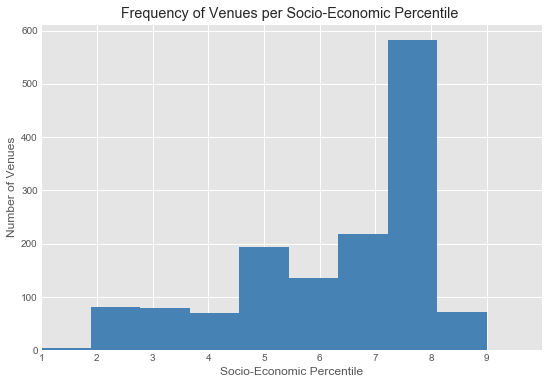

In [330]:

mpl.style.use(['ggplot']) # optional: for ggplot-like style
Israel_venues['Socio_Economic_Cluster'].plot(kind='hist', figsize=(8, 6),color='steelblue',
         edgecolor='none',bins = 9)
plt.xticks(range(10))
plt.xlim([1, 10])
plt.title("Frequency of Venues per Socio-Economic Percentile ")
plt.ylabel("Number of Venues")
plt.xlabel("Socio-Economic Percentile")
plt.savefig('Bias_For_SocEc.png')

We can easily see our data might contain a bias, resturant location is much more frequent in the higher half socio-economic percentile.
We cant fully acsertain if this is due to data bias, or a realistic phenomena represented in reality.

Regardless, we should consider this when constructing socio-economic categoriess.
We will try a 1-4,5-7,8-9 categorization



In [331]:
Categorical_value = pd.cut(Israel_venues['Socio_Economic_Cluster'], bins=[1, 4, 7, 9], include_lowest=True, labels=['low', 'mid', 'high'])


Israel_venues['Categorical_value'] = np.array(Categorical_value )
Israel_venues.head(10)


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,District,Population_Estimate_2018,Population_Census_2008,Area_KM,Density_Per_KM,Socio_Economic_Cluster,Socio_Economic_Ranking,latitude,longitude,Categorical_value
1,Acre,32.928173,35.075638,Uri Buri,32.920179,35.066798,Seafood Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638,low
3,Acre,32.928173,35.075638,Kukushka - Premium Snack Bar - קוקושקה,32.922540,35.069923,Tapas Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638,low
5,Acre,32.928173,35.075638,Hummus Said (חומוס סעיד),32.921535,35.069755,Middle Eastern Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638,low
6,Acre,32.928173,35.075638,Suhila Hummus (חומוס סוהילה),32.922480,35.071718,Mediterranean Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638,low
7,Acre,32.928173,35.075638,Doniana,32.919306,35.068455,Asian Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638,low
8,Acre,32.928173,35.075638,El Marsa,32.920104,35.070044,Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638,low
12,Acre,32.928173,35.075638,Cafè neto,32.927997,35.069201,Café,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638,low
16,Acre,32.928173,35.075638,Gallery Sam'an (גאלרי סמעאן),32.924856,35.081142,Middle Eastern Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638,low
17,Acre,32.928173,35.075638,Aroma,32.900969,35.092133,Café,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638,low
20,Acre,32.928173,35.075638,El Babor,32.928183,35.069171,Middle Eastern Restaurant,North,48930.0,46100.0,13.5,3362.0,4,96,32.928173,35.075638,low


In [332]:
Categorical_value2 = pd.cut(Israel_venues_uni['Socio_Economic_Cluster'], bins=[1, 4, 7, 9], include_lowest=True, labels=['low', 'mid', 'high'])


Israel_venues_uni['Categorical_value'] = np.array(Categorical_value2 )
Israel_venues_uni.head(10)

,City,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,District,Population_Estimate_2018,Population_Census_2008,Area_KM,Density_Per_KM,Socio_Economic_Cluster,Socio_Economic_Ranking,latitude,longitude,Categorical_value
0,Acre,0.0,0.0,0.058824,0.0,0.000,0.0,0.000000,0.0,0.0,...,North,48930.0,46100.0,13.50,3362.0,4,96,32.928173,35.075638,low
1,Afula,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,...,North,51737.0,40200.0,26.90,1611.7,5,129,32.607559,35.289086,mid
2,Arad,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,...,South,26451.0,23400.0,93.10,195.9,4,105,31.261220,35.214581,low
3,Arraba,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,...,North,25369.0,20600.0,8.25,3097.1,2,49,32.848613,35.335827,low
4,Ashdod,0.0,0.0,0.040000,0.0,0.000,0.0,0.000000,0.0,0.0,...,South,224628.0,204300.0,47.20,4783.9,5,118,31.797731,34.652992,mid
5,Ashkelon,0.0,0.0,0.000000,0.0,0.125,0.0,0.000000,0.0,0.0,...,South,140968.0,110600.0,47.80,2964.8,5,127,31.664487,34.573016,mid
6,Bat Yam,0.0,0.0,0.021277,0.0,0.000,0.0,0.042553,0.0,0.0,...,Tel Aviv,128774.0,130300.0,8.20,15758.4,5,130,32.015456,34.750528,mid
7,Beersheba,0.0,0.0,0.130435,0.0,0.000,0.0,0.043478,0.0,0.0,...,South,209002.0,193400.0,117.50,1751.7,5,136,31.243798,34.783592,mid
8,Beit She'an,0.0,0.0,0.000000,0.0,0.500,0.0,0.000000,0.0,0.0,...,North,18227.0,16900.0,7.30,2379.9,4,107,32.496752,35.497302,low
9,Beit Shemesh,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,...,Jerusalem,118676.0,72700.0,34.30,2866.6,2,25,31.746214,34.988683,low


Now that we have a categorical version of the Socio-economic score, lets check some more aspects of the data

In [4]:
# Start from here next time
#Israel_venues_uni = pd.read_csv(r'C:\Users\Owner\Documents\GitHub\Coursera_Capstone\City_level.csv')
#Israel_venues = pd.read_csv(r'C:\Users\Owner\Documents\GitHub\Coursera_Capstone\Venue_level.csv')

In [5]:
#lets exemine the frequency of venues in different districts, in comparison to some other district measures.
# for this we first need to get a numeric version of the district column

Israel_venues_uni['District'] = Israel_venues_uni['District'].astype('category')
Israel_venues['District'] = Israel_venues['District'].astype('category')


In [6]:

cat_columns_uni = Israel_venues_uni.select_dtypes(['category']).columns
cat_columns = Israel_venues.select_dtypes(['category']).columns

In [7]:
Israel_venues_uni['District_cat'] = Israel_venues_uni[cat_columns_uni].apply(lambda x: x.cat.codes)
Israel_venues['District_cat'] = Israel_venues[cat_columns_uni].apply(lambda x: x.cat.codes)

In [15]:

Israel_venues.groupby('District')['District_cat'].unique()


District
Center       [0]
Haifa        [1]
Jerusalem    [2]
North        [3]
South        [4]
Tel Aviv     [5]
Name: District_cat, dtype: object

In [16]:
Israel_venues_uni.groupby('District')['District_cat'].unique()

District
Center       [0]
Haifa        [1]
Jerusalem    [2]
North        [3]
South        [4]
Tel Aviv     [5]
Name: District_cat, dtype: object

In [172]:
Israel_venues_uni_bar =  Israel_venues_uni.groupby('District_cat').sum()
Israel_venues_uni_bar.insert(loc=0, column='Dist', value=[0,1,2,3,4,5])

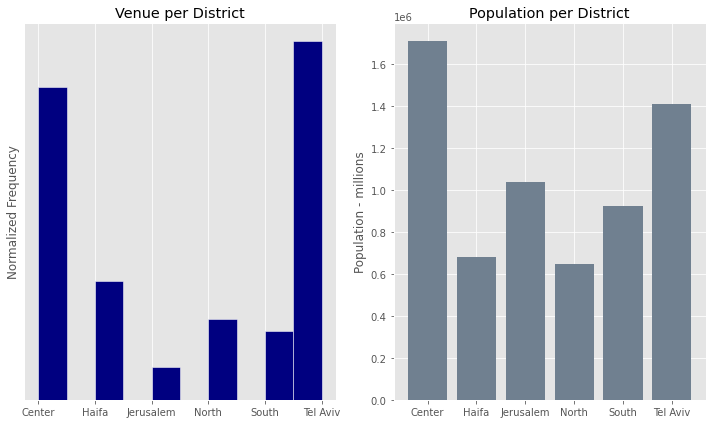

In [175]:
##lets compare and see if we find any outliers


mpl.style.use(['ggplot'])

fig = plt.figure()


ax1 = fig.add_subplot(121)

ax = Israel_venues.plot(y='District_cat',  ax=ax1, kind="hist", legend = False, title = "Venue per District" , figsize=(10, 6), density=1,edgecolor='white', color= 'navy')
ax.set_xticklabels(['Center', 'Haifa', 'Jerusalem','North','South','Tel Aviv'])
plt.xticks(range(6))
plt.yticks([])
plt.ylabel('Normalized Frequency')


#ax.annotate('Outlier!',(3, 0.2),
 #                xytext=(0.5, 0.5), textcoords='axes fraction',
  #               arrowprops = dict(facecolor='black',color='Orange'))



#ax.annotate('Both Outliers!',(4.3, 0.2),
 #                xytext=(0.6, 0.6), textcoords='axes fraction',
  #               arrowprops = dict(facecolor='black',color='Orange'))





ax2 = fig.add_subplot(122)

ax2.bar(Israel_venues_uni_bar['Dist'], Israel_venues_uni_bar['Population_Estimate_2018'], color=['slategrey'])
ax2.set_title('Population per District')
ax2.set_xticklabels(['Center', 'Haifa', 'Jerusalem','North','South','Tel Aviv'])
ax2.set_xticks(range(6))
ax2.set_ylabel('Population - millions')
#plt.yticks([])
#plt.ylabel('')






plt.tight_layout()

plt.show()

fig.savefig('Venue_freq_compared.png')

We can see that venue location does not allign with population count, Israel has a dominant metropolitan center in Tel-Aviv & its surronndings and resturants tend to open more frequently around that area. 

Lets run a correlation matrix for relevent variable, to see if we find any relationships in the datas

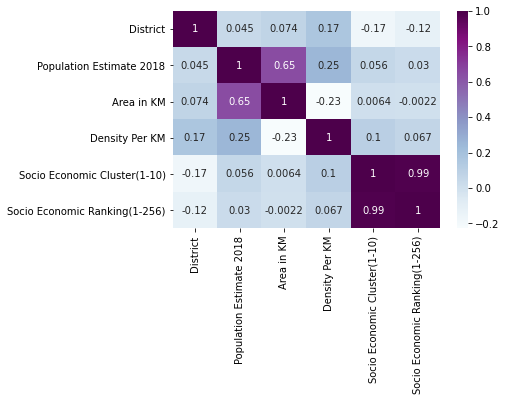

In [8]:
df_city_matrix = Israel_venues_uni[['District_cat','Population_Estimate_2018','Area_KM','Density_Per_KM','Socio_Economic_Cluster','Socio_Economic_Ranking']]
corrMatrix = df_city_matrix.corr()

x_axis_labels = ['District','Population Estimate 2018','Area in KM','Density Per KM','Socio Economic Cluster(1-10)','Socio Economic Ranking(1-256)']
y_axis_labels = ['District','Population Estimate 2018','Area in KM','Density Per KM','Socio Economic Cluster(1-10)','Socio Economic Ranking(1-256)']

sns_plot = sns.heatmap(corrMatrix, annot=True,xticklabels=x_axis_labels ,yticklabels=y_axis_labels, cmap="BuPu")
fig = sns_plot.get_figure()



fig.savefig('corr_matrix.png')

Now we can see that the strongest internal correlation in the data is Population and City size.
lets check the relationship between those two some more

(0.0, 966055.7567467199)

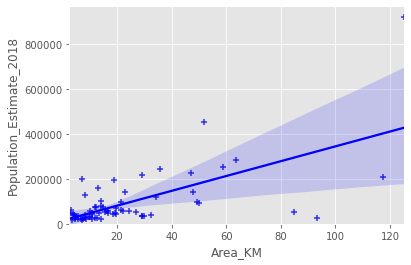

In [51]:
mpl.style.use(['ggplot'])
sns.regplot(x="Area_KM", y='Population_Estimate_2018', data=Israel_venues_uni,fit_reg=True, truncate = True, marker="+", color="b")
plt.ylim(0,)

In [38]:
x = Israel_venues_uni[["Area_KM"]]
y = Israel_venues_uni[['Population_Estimate_2018']]
lm=LinearRegression()
lm.fit(x,y)

Yhat = lm.predict(x)
rms = sqrt(mean_squared_error(y,Yhat))

print('The intercept for this model is' ,lm.intercept_)
print('The coefficent for this model is' , lm.coef_)
print('The R^2 score for this model is' ,lm.score(x, y))
print('The MSE for this model is' ,mean_squared_error(y,Yhat))
print('The RMSE for this model is' ,rms)

The intercept for this model is [14545.990091]
The coefficent for this model is [[3295.07170445]]
The R^2 score for this model is 0.4228627567446652
The MSE for this model is 9166404908.597395
The RMSE for this model is 95741.34377894115


Make sure that the errors are random, and the linear option is appropriate

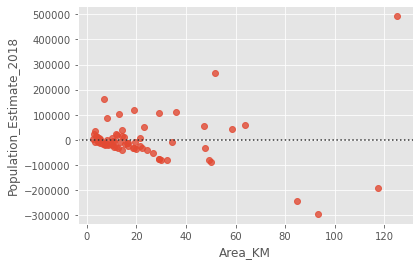

In [52]:
sns.residplot(x="Area_KM", y='Population_Estimate_2018', data=Israel_venues_uni)

Lets check if there might be an intervening relationship in the described model - specificaly if density might also be a good predictor of population size

In [39]:
x = Israel_venues_uni[["Area_KM",'Density_Per_KM']]
y = Israel_venues_uni[['Population_Estimate_2018']]
lm=LinearRegression()
lm.fit(x,y)

Yhat= lm.predict(x)
rms = sqrt(mean_squared_error(y,Yhat))


print('The intercept for this model is' ,lm.intercept_)
print('The coefficent for this model is' , lm.coef_)
print('The R^2 score for this model is' ,lm.score(x, y))
print('The MSE for this model is' ,mean_squared_error(y,Yhat))
print('The RMSE for this model is' ,rms)

The intercept for this model is [-56393.05183989]
The coefficent for this model is [[3784.67224659   12.64953486]]
The R^2 score for this model is 0.5927924953023633
The MSE for this model is 6467489169.169314
The RMSE for this model is 80420.70112333835


In [40]:
x = Israel_venues_uni[['Density_Per_KM']]
y = Israel_venues_uni[['Population_Estimate_2018']]
lm=LinearRegression()
lm.fit(x,y)

Yhat = lm.predict(x)
rms = sqrt(mean_squared_error(y,Yhat))

print('The intercept for this model is' ,lm.intercept_)
print('The coefficent for this model is' , lm.coef_)
print('The R^2 score for this model is' ,lm.score(x, y))
print('The MSE for this model is' ,mean_squared_error(y,Yhat))
print('The RMSE for this model is' ,rms)

The intercept for this model is [54580.62814183]
The coefficent for this model is [[7.5571935]]
The R^2 score for this model is 0.06398363130012996
The MSE for this model is 14866316698.231361
The RMSE for this model is 121927.50591327358


As we can see, by itself density is a poor predictor of population size, but with Area_KM, it enhances the model.

We will not preform further model eveluation due to the reletivly small sample size

## its time to move on to clustering  

In [41]:
# lets maintain only relevemt columns in our data:

db_data = Israel_venues_uni.drop(['City','District','Population_Estimate_2018','Population_Census_2008','Area_KM'
                                 ,'Density_Per_KM','Socio_Economic_Cluster', 'Socio_Economic_Ranking', 'latitude', 'longitude','Categorical_value','District_cat'], axis=1)


The elbow method will be used to determine optimal k - cluster groups

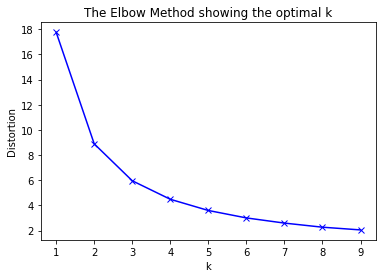

In [42]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(db_data)
    kmeanModel.fit(db_data)
    distortions.append(sum(np.min(cdist(db_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / db_data.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()



Allthough there is some distortion left, 4 clusters will be selected to maintain a reasonable amount of clusters for the amount of cities we have in the data

In [43]:
kclusters = 4


# run k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 15).fit(db_data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2])

In [44]:
Israel_venues_uni.insert(0, 'Cluster Labels', kmeans.labels_)
Israel_venues_uni.head()

,Cluster Labels,Unnamed: 0,City,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Population_Estimate_2018,Population_Census_2008,Area_KM,Density_Per_KM,Socio_Economic_Cluster,Socio_Economic_Ranking,latitude,longitude,Categorical_value,District_cat
0,3,0,Acre,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,...,48930.0,46100.0,13.50,3362.0,4,96,32.928173,35.075638,low,3
1,3,1,Afula,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,51737.0,40200.0,26.90,1611.7,5,129,32.607559,35.289086,mid,3
2,3,2,Arad,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,26451.0,23400.0,93.10,195.9,4,105,31.261220,35.214581,low,4
3,3,3,Arraba,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,25369.0,20600.0,8.25,3097.1,2,49,32.848613,35.335827,low,3
4,3,4,Ashdod,0.0,0.0,0.040000,0.0,0.0,0.0,0.0,...,224628.0,204300.0,47.20,4783.9,5,118,31.797731,34.652992,mid,4


In [64]:
# create map
map_clusters = folium.Map(location=[31, 35], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Israel_venues_uni['latitude'], Israel_venues_uni['longitude'], Israel_venues_uni['City'], Israel_venues_uni['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [65]:
# save as an html file
map_clusters.save("Cities_Clustered.html")

In [46]:
Cluster_means = Israel_venues_uni.groupby('Cluster Labels').mean()

In [47]:
Cluster_means.head()

,Unnamed: 0,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Wings Joint,Population_Estimate_2018,Population_Census_2008,Area_KM,Density_Per_KM,Socio_Economic_Cluster,Socio_Economic_Ranking,latitude,longitude,District_cat
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,25.5,0.000000,0.000000,0.043752,0.000896,0.007574,0.002632,0.054186,0.003673,0.000000,...,0.000000,119142.055556,102711.111111,21.583333,5185.516667,5.833333,156.611111,32.354290,35.003166,2.000000
1,43.5,0.002455,0.000000,0.037497,0.000000,0.022344,0.007876,0.032026,0.005062,0.000000,...,0.001048,73275.333333,62161.111111,16.872222,3954.755556,5.611111,152.055556,32.233229,34.949338,2.444444
2,61.5,0.055556,0.027778,0.013047,0.000000,0.005135,0.002315,0.037963,0.000000,0.000000,...,0.000000,79788.888889,68022.222222,19.716667,3463.722222,4.722222,120.888889,32.339218,35.018166,1.611111
3,8.0,0.002121,0.004474,0.033075,0.000000,0.046569,0.000000,0.020570,0.001014,0.004706,...,0.002046,88675.235294,75082.352941,34.350000,6362.870588,4.529412,112.941176,31.879966,34.971438,3.176471


In [49]:
#Cluster_means.insert(loc=0, column='Clusters', value=[0,1,2,3])
Cluster_means.drop(['Population_Estimate_2018','Population_Census_2008','Area_KM'
                                 ,'Density_Per_KM','Socio_Economic_Cluster', 'Socio_Economic_Ranking', 'latitude', 'longitude','District_cat'], axis=1, inplace=True)

Cluster_means.head()

,Unnamed: 0,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Soup Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,25.5,0.000000,0.000000,0.043752,0.000896,0.007574,0.002632,0.054186,0.003673,0.000000,...,0.001235,0.001208,0.000000,0.006685,0.056575,0.001964,0.001736,0.000000,0.000000,0.000000
1,43.5,0.002455,0.000000,0.037497,0.000000,0.022344,0.007876,0.032026,0.005062,0.000000,...,0.000000,0.001684,0.000000,0.022517,0.014642,0.000772,0.002315,0.000000,0.000000,0.001048
2,61.5,0.055556,0.027778,0.013047,0.000000,0.005135,0.002315,0.037963,0.000000,0.000000,...,0.000926,0.000000,0.000000,0.027511,0.031313,0.000000,0.004167,0.000000,0.001852,0.000000
3,8.0,0.002121,0.004474,0.033075,0.000000,0.046569,0.000000,0.020570,0.001014,0.004706,...,0.000000,0.001089,0.002353,0.006740,0.027208,0.008575,0.002121,0.002353,0.001014,0.002046


In [109]:
num_top_venues = 11

for hood in Cluster_means['Clusters']:
    print("----"+str(hood)+"----")
    temp = Cluster_means[Cluster_means['Clusters'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----0----
                        venue   freq
0                  Unnamed: 0  25.50
1                        Café   0.29
2   Middle Eastern Restaurant   0.09
3            Sushi Restaurant   0.06
4          Italian Restaurant   0.06
5                      Bakery   0.05
6                Burger Joint   0.05
7        Fast Food Restaurant   0.05
8                  Restaurant   0.05
9            Asian Restaurant   0.04
10                Coffee Shop   0.04


----1----
                        venue   freq
0                  Unnamed: 0  61.50
1   Middle Eastern Restaurant   0.24
2                        Café   0.16
3         American Restaurant   0.06
4                  Restaurant   0.05
5    Mediterranean Restaurant   0.05
6                      Bakery   0.04
7              Ice Cream Shop   0.04
8            Sushi Restaurant   0.03
9          Falafel Restaurant   0.03
10                Coffee Shop   0.03


----2----
                        venue  freq
0                  Unnamed: 0  8.00
1     

Now we have some details about the clusters weve created.
before we move on to our findings, we know that there is a larger amount of reasturants in mid-high Socio-Economic Cities - lets try and create a cluster analysis for those cities
only, and see if we can further differantiate those cities, and supply our client with more precise reccomendations.

In [132]:
High_soc = Israel_venues_uni.loc[Israel_venues_uni['Categorical_value'] != 'low']
High_soc.drop(['Cluster Labels'], axis=1, inplace=True)
High_soc.shape

G:\Anaconda3\envs\Non-root Python\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(42, 75)

Lets redo the clustering procces

In [133]:
db_data1 = High_soc.drop(['City','District','Population_Estimate_2018','Population_Census_2008','Area_KM'
                                 ,'Density_Per_KM','Socio_Economic_Cluster', 'Socio_Economic_Ranking', 'latitude', 'longitude','Categorical_value','District_cat'], axis=1)

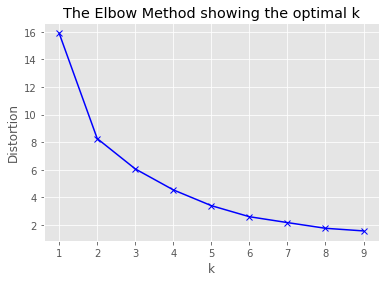

In [134]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(db_data1)
    kmeanModel.fit(db_data1)
    distortions.append(sum(np.min(cdist(db_data1, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / db_data1.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()



In [135]:
kclusters = 2


# run k-means clustering
kmeans2 = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 15).fit(db_data1)

# check cluster labels generated for each row in the dataframe
kmeans2.labels_ 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [136]:
High_soc.insert(0, 'Cluster Labels', kmeans2.labels_)
High_soc.head()

,Cluster Labels,Unnamed: 0,City,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Population_Estimate_2018,Population_Census_2008,Area_KM,Density_Per_KM,Socio_Economic_Cluster,Socio_Economic_Ranking,latitude,longitude,Categorical_value,District_cat
1,1,1,Afula,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,...,51737.0,40200.0,26.9,1611.7,5,129,32.607559,35.289086,mid,3
4,1,4,Ashdod,0.0,0.0,0.040000,0.0,0.000,0.0,0.000000,...,224628.0,204300.0,47.2,4783.9,5,118,31.797731,34.652992,mid,4
5,1,5,Ashkelon,0.0,0.0,0.000000,0.0,0.125,0.0,0.000000,...,140968.0,110600.0,47.8,2964.8,5,127,31.664487,34.573016,mid,4
6,1,6,Bat Yam,0.0,0.0,0.021277,0.0,0.000,0.0,0.042553,...,128774.0,130300.0,8.2,15758.4,5,130,32.015456,34.750528,mid,5
7,1,7,Beersheba,0.0,0.0,0.130435,0.0,0.000,0.0,0.043478,...,209002.0,193400.0,117.5,1751.7,5,136,31.243798,34.783592,mid,4


In [138]:
# create map
map_clusters2 = folium.Map(location=[31, 35], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(High_soc['latitude'], High_soc['longitude'], High_soc['City'], High_soc['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

In [139]:
# save as an html file
map_clusters2.save("Cities_Clustered2.html")

In [140]:
Cluster_means2 = High_soc.groupby('Cluster Labels').mean()

In [142]:
Cluster_means2

,Unnamed: 0,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Wings Joint,Population_Estimate_2018,Population_Census_2008,Area_KM,Density_Per_KM,Socio_Economic_Cluster,Socio_Economic_Ranking,latitude,longitude,District_cat
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,50.250000,0.002210,0.00000,0.037611,0.000000,0.009958,0.009172,0.056172,0.004555,0.000000,...,0.000943,104184.150000,88980.000000,21.375000,4334.790000,6.850000,187.400000,32.264267,34.932851,1.700000
1,18.409091,0.000842,0.00266,0.054481,0.000733,0.018445,0.002154,0.049536,0.003789,0.003636,...,0.000784,92591.681818,82359.090909,27.690909,5773.254545,6.409091,173.636364,32.212467,34.955848,2.545455


In [143]:
Cluster_means2.insert(loc=0, column='Clusters', value=[0,1])
Cluster_means2.drop(['Population_Estimate_2018','Population_Census_2008','Area_KM'
                                 ,'Density_Per_KM','Socio_Economic_Cluster', 'Socio_Economic_Ranking', 'latitude', 'longitude','District_cat'], axis=1, inplace=True)

Cluster_means2.head()

,Clusters,Unnamed: 0,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,...,Soup Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,0,50.250000,0.002210,0.00000,0.037611,0.000000,0.009958,0.009172,0.056172,0.004555,...,0.000833,0.001515,0.000000,0.00803,0.041360,0.000694,0.005833,0.000000,0.001667,0.000943
1,1,18.409091,0.000842,0.00266,0.054481,0.000733,0.018445,0.002154,0.049536,0.003789,...,0.000000,0.001830,0.001818,0.00988,0.042991,0.005560,0.002262,0.001818,0.000784,0.000784


In [145]:
num_top_venues = 11

for hood in Cluster_means2['Clusters']:
    print("----"+str(hood)+"----")
    temp = Cluster_means2[Cluster_means2['Clusters'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----0----
                        venue   freq
0                  Unnamed: 0  50.25
1                        Café   0.29
2   Middle Eastern Restaurant   0.10
3          Italian Restaurant   0.06
4                      Bakery   0.06
5                Burger Joint   0.04
6            Asian Restaurant   0.04
7                 Coffee Shop   0.04
8              Ice Cream Shop   0.04
9                  Restaurant   0.04
10           Sushi Restaurant   0.04


----1----
                        venue   freq
0                  Unnamed: 0  18.41
1                        Café   0.28
2   Middle Eastern Restaurant   0.06
3          Italian Restaurant   0.06
4                Burger Joint   0.06
5            Asian Restaurant   0.05
6                      Bakery   0.05
7                 Coffee Shop   0.05
8                  Restaurant   0.05
9            Sushi Restaurant   0.04
10       Fast Food Restaurant   0.04




## Results and Discussion <a name="results"></a>

When exploring the properties of the dataset, a trend wad found towards venues being more densely located in cities that are characterized by a high socio-economic index.
it is uncertain whether this trend is represented in reality, or if it may be an inherent bias of the Foursquare API used to obtain the venue information.
The high end of the Socioeconomic index cities ( the index: 8, for this dataset), included 655 venues out of the total 1437 relevant venues returned from the API, 45.6% of all venues.

After exploring the venue frequency per socio-economic categorization, the distribution of venues by area was examined; 
Venues were found to be more frequent in the geographical center of Israel, and specifically in the Tel-Aviv area (69% combined for both districts).
When compared to population numbers for those districts, it can be seen that venues are over-represented (48.6% of the population for both districts), this might be explained by the Tel-Aviv metropolitan area being a center of Israeli economics and leisure, drawing people from other districts of Israel on a daily basis.

The clearest under-representation of venues can be seen in the Jerusalem district (3.34% of venues compared to 16.2% of the population), this finding is likely a result of the Foursquare API's bias. 
Based on this disparity, conclusions regarding preferable location according to venue frequency should be made with caution.


A correlation matrix was run to further understand the relationships between relevant numeric & categorical variables in the data.

- No strong relationships were found between either District or Socio-Economic index to other variables in the dataset (Both variables used to measure Socio-Economic city status were congruent)

- A correlation of 0.25 was found between Population per city and Density per KM.

- A correlation of -0.23 was found between Density in KM and Area in KM

- A correlation of 0.65 was found between Population per city and city area in KM, this is the strongest relationship found in the dataset, and therefore it will be explored further.




A linear regression model was built with Area in KM as a predictor and Population size as the predicted variable.

The intercept for this model is: 14545.990091

The coefficient for this model is: 3295.07170445

The R^2 score for this model is: 0.4228627567446652

The RMSE for this model is 95741.34377894115

A residuals plot was created to approve that the linear model was adequate.

Density was checked to examine if it might be an intervening variable in the model, on its own, it was found to be a poor predictor (R^2 = 0.06398363130012996, RMSE = 121927.50591327358 ).
When a Multiple linear model was constructed using both variables as predictors, an enhanced model was found:

The intercept for this model is: -56393.05183989 

The coefficients for this model are:3784.67224659,  12.64953486

The R^2 score for this model is: 0.5927924953023633

The RMSE for this model is: 80420.70112333835

## Cluster Results

A K-means clustering model was constructed on the basis of a dataset containing the frequency of venue types in every given city.

The ideal number of clusters was assessed using the elbow method, and a 4 cluster model was chosen.

The clusters can be characterized as such:

- Cluster 1 

 **"Free Urbanites"** : High population cities, high socio-economic index & relatively less dense.  Preferred venus are:


1                        Café   0.29

2   Middle Eastern Restaurant   0.09

3            Sushi Restaurant   0.06

4          Italian Restaurant   0.06

5                      Bakery   0.05

6                Burger Joint   0.05

7        Fast Food Restaurant   0.05

8                  Restaurant   0.05

9            Asian Restaurant   0.04

10                Coffee Shop   0.04



- Cluster 2 

 **"Well-To-Do & Satisfied"** : Mid-High Socio-economic index, low density & live in small cities with small population size.  Preferred venus are:


1   Middle Eastern Restaurant   0.24

2                        Café   0.16

3         American Restaurant   0.06

4                  Restaurant   0.05

5    Mediterranean Restaurant   0.05

6                      Bakery   0.04

7              Ice Cream Shop   0.04

8            Sushi Restaurant   0.03

9          Falafel Restaurant   0.03

10                Coffee Shop   0.03


- Cluster 3 

 **"Comfy Middle-Class"** : Small to medium population size, small in area but not dense, Socio economically index low to medium.  Preferred venus are:


1                        Café  0.31

2   Middle Eastern Restaurant  0.11

3                 Coffee Shop  0.07

4              Breakfast Spot  0.05

5                   BBQ Joint  0.05

6                  Restaurant  0.04

7                Burger Joint  0.04

8            Asian Restaurant  0.03

9          Seafood Restaurant  0.03

10           Sushi Restaurant  0.03


- Cluster 4 
 
 **"Urban Warriors"** : Very high density in very large cities, Socio-economically low.  Preferred venus are:



1                        Café   0.33

2   Middle Eastern Restaurant   0.08

3          Italian Restaurant   0.06

4                 Pizza Place   0.05

5                Burger Joint   0.05

6                  Restaurant   0.04

7              Ice Cream Shop   0.04

8          Falafel Restaurant   0.04

9            Asian Restaurant   0.04

10                     Bakery   0.03


Due to the tendency of venues to be located in Socio-economically high cities in greater concentration, a second k-means clustering analysis was performed to attempt a greater focus of this subset of the cities in the data.

For this analysis, 2 clusters were selected due to the relatively low sample size.

The clusters can be characterized as such:


- Cluster 1

 **"Center-Stage"** : High population counts with medium density in medium-sized cities, very high socio-economic index.  Prefered venus are:
 
 
1                        Café   0.29

2   Middle Eastern Restaurant   0.10

3          Italian Restaurant   0.06

4                      Bakery   0.06

5                Burger Joint   0.04

6            Asian Restaurant   0.04

7                 Coffee Shop   0.04

8              Ice Cream Shop   0.04

9                  Restaurant   0.04

10           Sushi Restaurant   0.04


- Cluster 2

 **"Closing on the Spotlight"**: Smaller population counts and higher density cities, high socio-economic index.  Preferred venus are:

1                        Café   0.28

2   Middle Eastern Restaurant   0.06

3          Italian Restaurant   0.06

4                Burger Joint   0.06

5            Asian Restaurant   0.05

6                      Bakery   0.05

7                 Coffee Shop   0.05

8                  Restaurant   0.05

9            Sushi Restaurant   0.04

10       Fast Food Restaurant   0.04



## Conclusion & Recommendations <a name="conclusion"></a>

To begin with, our first meaningful finding was that relevant venues tend to more frequently appear at the Center & Tel-Aviv Districts of Israel, and in cities with higher socio-economic index.
On the basis of this finding, we can recommend to stakeholders that a greater demand exists in these areas - and the likelihood of financial success might increase if the choice is made to open a restaurant in those areas of Israel.

This recommendation must be limited though, as it might be derived from the data's bias rather than a reliable depiction of venue location. 
What we can say with a higher likelihood is that the presented findings can be interpreted as more reliable for these areas that have a higher frequency of venues.


The clearest and most distinct finding that can be derived from the clustering analysis is the overwhelming popularity of Cafe venues, throughout almost all clusters - Cafes are the most common venue.
We can easily recommend that the stakeholder open a Cafe, regardless of area, under the assumption that frequency is an indication of demand.
The high amount might also indicate a saturated market for these specific venues, competition might be particularly harsh and larger, more veteran companies might be harder to compete with.

It should also be mentioned that no clear geographic area preferences for venues were found - as each cluster segment clearly contains cities from across Israel.

### Recomendations per Cluster ###

Our first cluster analysis can help define further recommendations:

A clear outlier among clusters are the "Well-To-Do & Satisfied" group, this group is the only one not dominated by Cafes, with a higher frequency of Middle Eastern restaurants.
If the stakeholders are interested in opening a venue in these locations, a Middle Eastern restaurant clearly seems to have great demand.
If the stakeholder is more interested in a niche among these cities, American restaurants seem to have distinct popularity here.


All other clusters, as mentioned, are dominated by Cafes, with Middle Eastern restaurants being consistent runner-ups.
For each of these we can still make niche market recommendations:

For the "Free Urbanites" - Sushi restaurants are in higher demand than in any other segment.

For the "Comfy Middle-Class" - Breakfast spots & BBQ joints seem to have high popularity.

For the "Urban Warriors" -  Italian restaurants, Pizza places & Burger joints are preferred

Our second clustering analysis, focusing on mid to high index socio-economical cities - also has some distinctions to provide:

The "Center-Stage" cluster has more demand for Bakeries, while the "Closing on the Spotlight" cluster a higher demand for Burger joints.





## Limitations

All results and recommendations throughout this project are dependent on the collected data's reliability in reflecting reality - as was previously established, the Foursquare API used to gather venues for this project seems to have a bias towards venues in the Center & Tel-Aviv Districts of Israel. 
Also, the collected information from Wikipedia regarding Israeli cities is not all fully updated - Population counts were estimated only, and for 2018.
Other aspects of the data might have also changed somewhat for a portion of the cities (Most likely increases in density and in some cases increases city size)